# チュートリアル: ノイズデータからの信号抽出

このチュートリアルでは、`gwexpy` を使用してノイズに埋もれた微弱な信号を検出し、抽出する方法をデモンストレーションします。
ガウシアンノイズの中に単色信号（正弦波）が隠されているシナリオをシミュレーションします。

**ワークフロー:**
1.  **データ生成**: ノイズを含む時系列データを生成します。
2.  **データ確認**: 生データを可視化します（時間領域）。
3.  **スペクトル解析**: 振幅スペクトル密度 (ASD) を使用して信号周波数を特定します。
4.  **フィルタリング**: バンドパスフィルタを適用して信号を抽出します。
5.  **パラメータ推定**: 抽出された信号をフィットさせ、その特性を定量化します。


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from gwexpy import TimeSeries

## 1. データ生成

サンプルレート 4096 Hz で 32秒分のデータをシミュレーションします。
ガウス白色ノイズに、振幅の小さい **123.4 Hz** の正弦波を注入します。


In [2]:
# パラメータ
duration = 32  # 秒
sample_rate = 4096  # Hz
signal_freq = 123.4  # Hz
signal_amp = 0.5
noise_std = 5.0  # ノイズは信号よりはるかに大きい

# 時間配列
t = np.linspace(0, duration, int(duration * sample_rate), endpoint=False)

# ノイズ生成（白色ガウスノイズ）
# 実際のシナリオでは、これが測定データになります
noise = np.random.normal(0, noise_std, size=len(t))

# 信号生成
clean_signal = signal_amp * np.sin(2 * np.pi * signal_freq * t)

# 合成
data = noise + clean_signal

# TimeSeries オブジェクトの作成
ts = TimeSeries(data, t0=0, sample_rate=sample_rate, name="Noisy Data", unit="V")

print(ts)


TimeSeries([ 7.46539014, -2.4676698 , -2.14109017, ...,
             0.06460582, -2.31899961,  1.85104233]
           unit: V,
           t0: 0.0 s,
           dt: 0.000244140625 s,
           name: Noisy Data,
           channel: None)


## 2. 時間領域での確認

生の時系列データをプロットしても、信号はノイズに埋もれており、肉眼では確認できません。


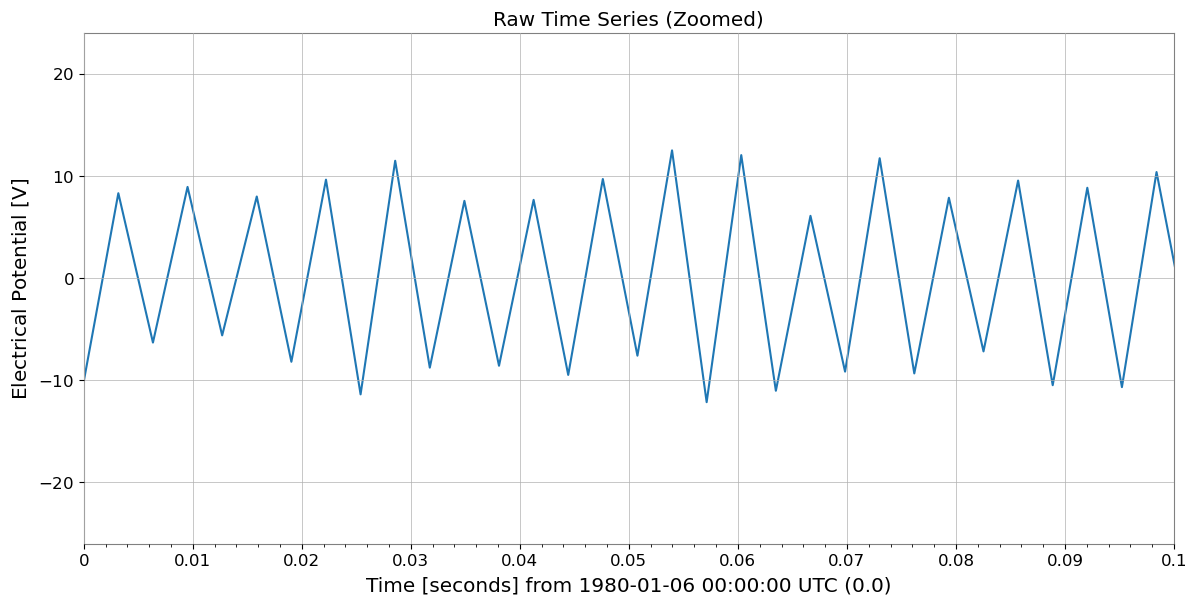

In [3]:
plot = ts.plot()
plot.gca().set_xlim(0, 0.1)  # 0.1秒まで拡大
plot.gca().set_title("Raw Time Series (Zoomed)")
plt.show()


## 3. スペクトル解析

隠れた周期信号を見つけるために、振幅スペクトル密度 (ASD) を計算します。
白色ノイズの ASD は平坦ですが、正弦波は鋭いピークとして現れるはずです。


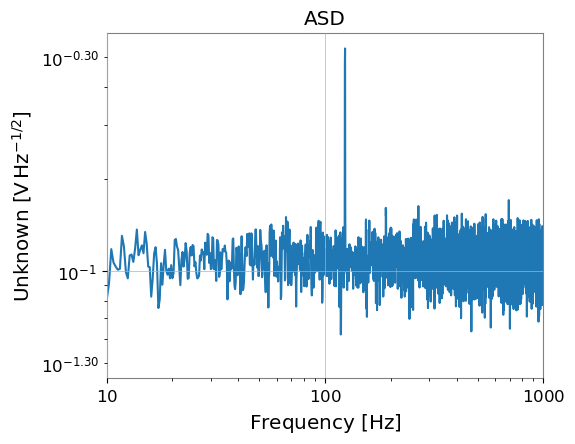

In [4]:
# ASDを計算
# fftlength=4 は、分散を減らすために4秒間のチャンクを平均化することを意味します
asd = ts.asd(fftlength=4, method="welch")

plot = asd.plot()
plot.gca().set_xlim(10, 1000)
plot.gca().set_yscale('log')
plot.gca().set_title("ASD")
plt.show()


## 4. フィルタリング

123 Hz 付近のピークを特定したら、**バンドパスフィルタ** を適用して、この周波数範囲外のノイズを抑制できます。
110 Hz から 130 Hz の間をフィルタリングしてみましょう。


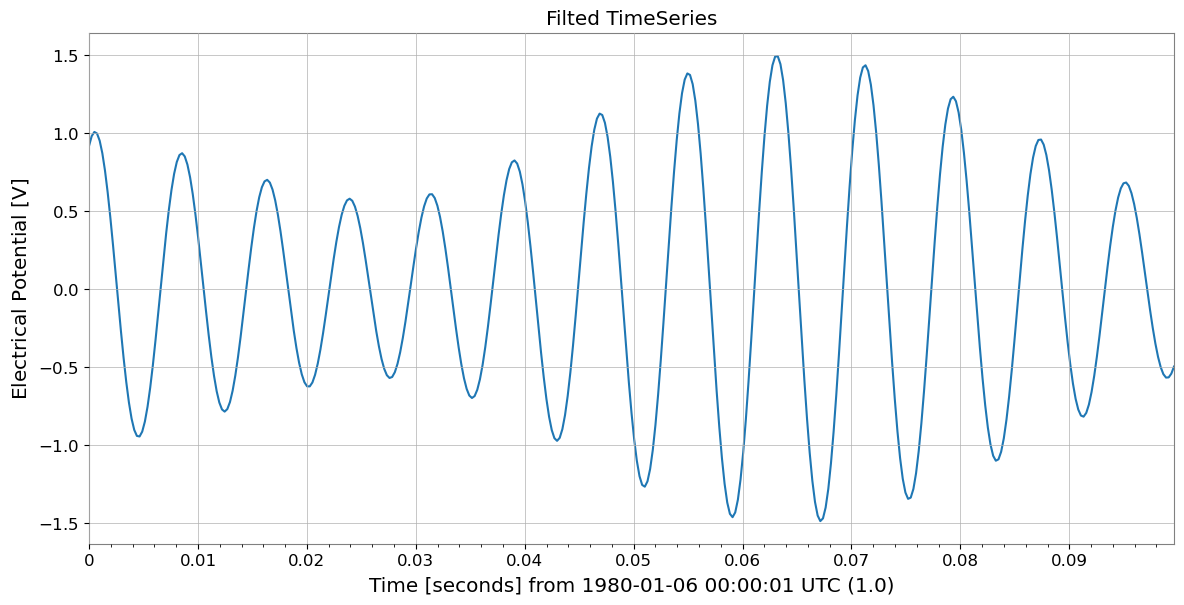

Standard Deviation: 0.7424
Sine-wave RMS (A/sqrt(2)): 0.3536


In [5]:
# バンドパスフィルタ
filtered_ts = ts.bandpass(110, 130).crop(1, 1.1)

# 生データとフィルタリング後のデータを比較
plot = filtered_ts.plot()
plot.gca().set_title("Filted TimeSeries")
plt.show()

# 振幅の安定性を検証
print(f"Standard Deviation: {filtered_ts.std().value:.4f}")
print(f"Sine-wave RMS (A/sqrt(2)): {signal_amp/np.sqrt(2):.4f}")


## 5. パラメータ推定 (フィッティング)

最後に、フィルタリングされたデータに正弦波モデルをフィットさせて、振幅と周波数を正確に推定します。
あるいは、周波数領域のピークにガウス関数やローレンツ関数をフィットさせることもできます。

ここでは、`gwexpy.fitting` を使用して時系列での単純なフィットを試してみましょう。
(注: 一般的な正弦波フィッティングには適切な初期推定値が必要です)。


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.61e+05 (χ²/ndof = 647.7) │              Nfcn = 615              │
│ EDM = 2.39e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

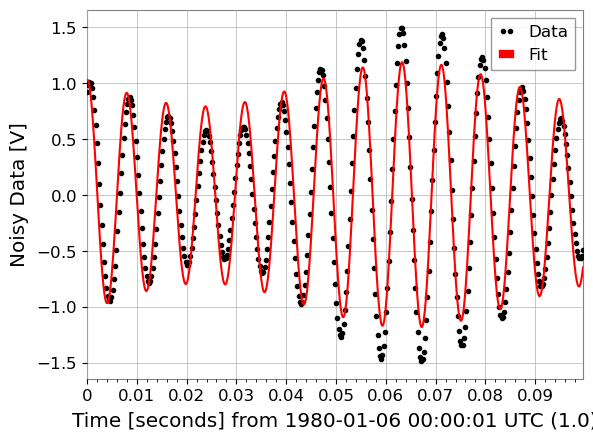

In [ ]:
# フィッティング用の正弦波モデルを定義
def sine_model(t, amp, freq, phase, amp2, freq2, phase2):
    return amp * np.sin(2 * np.pi * freq * t + phase) *(1 + amp2 * np.sin(2 * np.pi * freq2 * t + phase2))

# 高速化と可視化のためにフィッティング用の短いセグメントを切り出す
segment = filtered_ts

# 目視による初期推定値
p0 = {'amp': 0.5, 'freq': 123, 'phase': 0, 'amp2': 0.05, 'freq2': 10, 'phase2': 0}
limits = {'freq': (110, 130), 'amp': (0.1, 5), 'amp2': (0, 0.2), 'freq2': (0, 50)}

# フィットを実行
# 注: 'fit' メソッドは enable_series_fit() を呼び出したために利用可能です
result = segment.fit(sine_model, p0=p0, limits=limits, sigma=0.01)

print(result)

# データとベストフィットをプロット
ax = result.plot()
plt.show()